# Causal Inference Demo Notebook

Load necessary libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from stochtree import BCFModel
from sklearn.model_selection import train_test_split

Generate sample data

In [2]:
# RNG
rng = np.random.default_rng()

# Generate covariates and basis
n = 1000
p_X = 5
X = rng.uniform(0, 1, (n, p_X))
pi_X = 0.25 + 0.5*X[:,0]
Z = rng.binomial(1, pi_X, n).astype(float)

# Define the outcome mean functions (prognostic and treatment effects)
mu_X = pi_X*5 + 2*X[:,2]
tau_X = (X[:,1]*2 - 1)

# Generate outcome
epsilon = rng.normal(0, 1, n)
y = mu_X + tau_X*Z + epsilon

Test-train split

In [3]:
sample_inds = np.arange(n)
train_inds, test_inds = train_test_split(sample_inds, test_size=0.5)
X_train = X[train_inds,:]
X_test = X[test_inds,:]
Z_train = Z[train_inds]
Z_test = Z[test_inds]
y_train = y[train_inds]
y_test = y[test_inds]
pi_train = pi_X[train_inds]
pi_test = pi_X[test_inds]
mu_train = mu_X[train_inds]
mu_test = mu_X[test_inds]
tau_train = tau_X[train_inds]
tau_test = tau_X[test_inds]

Run BCF

In [4]:
bcf_model = BCFModel()
bcf_model.sample(X_train, Z_train, y_train, pi_train, X_test, Z_test, pi_test, num_gfr=10, num_mcmc=100)

Inspect the MCMC (BART) samples

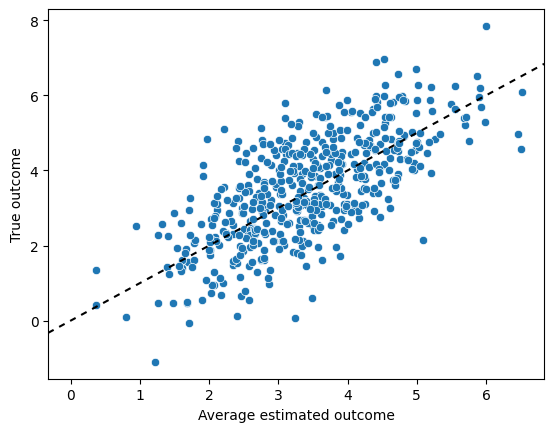

In [5]:
forest_preds_y_mcmc = bcf_model.y_hat_test
y_avg_mcmc = np.squeeze(forest_preds_y_mcmc).mean(axis = 1, keepdims = True)
y_df_mcmc = pd.DataFrame(np.concatenate((np.expand_dims(y_test,1), y_avg_mcmc), axis = 1), columns=["True outcome", "Average estimated outcome"])
sns.scatterplot(data=y_df_mcmc, x="Average estimated outcome", y="True outcome")
plt.axline((0, 0), slope=1, color="black", linestyle=(0, (3,3)))
plt.show()

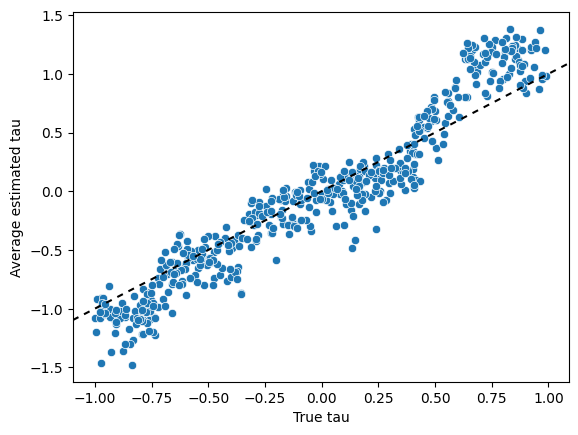

In [6]:
forest_preds_tau_mcmc = bcf_model.tau_hat_test
tau_avg_mcmc = np.squeeze(forest_preds_tau_mcmc).mean(axis = 1, keepdims = True)
tau_df_mcmc = pd.DataFrame(np.concatenate((np.expand_dims(tau_test,1), tau_avg_mcmc), axis = 1), columns=["True tau", "Average estimated tau"])
sns.scatterplot(data=tau_df_mcmc, x="True tau", y="Average estimated tau")
plt.axline((0, 0), slope=1, color="black", linestyle=(0, (3,3)))
plt.show()

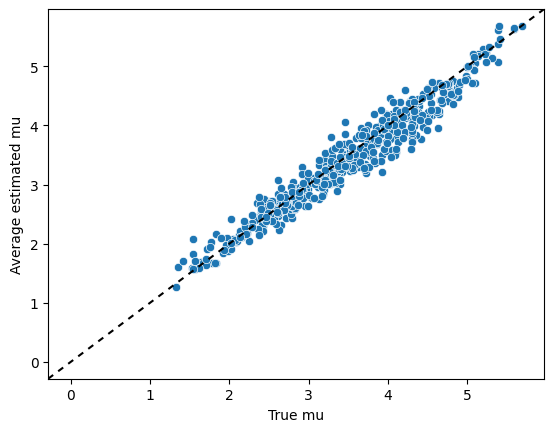

In [7]:
forest_preds_mu_mcmc = bcf_model.mu_hat_test
mu_avg_mcmc = np.squeeze(forest_preds_mu_mcmc).mean(axis = 1, keepdims = True)
mu_df_mcmc = pd.DataFrame(np.concatenate((np.expand_dims(mu_test,1), mu_avg_mcmc), axis = 1), columns=["True mu", "Average estimated mu"])
sns.scatterplot(data=mu_df_mcmc, x="True mu", y="Average estimated mu")
plt.axline((0, 0), slope=1, color="black", linestyle=(0, (3,3)))
plt.show()

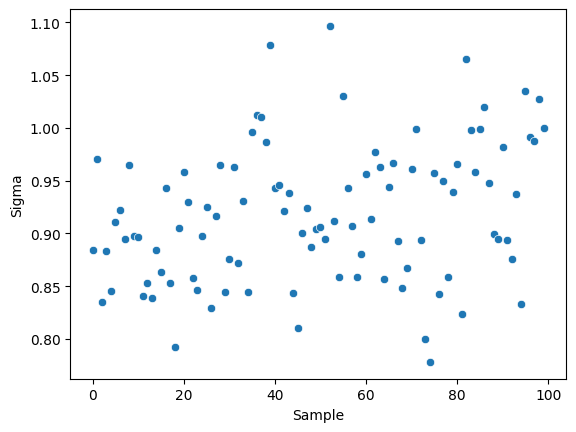

In [8]:
sigma_df_mcmc = pd.DataFrame(np.concatenate((np.expand_dims(np.arange(bcf_model.num_samples - bcf_model.num_gfr),axis=1), np.expand_dims(bcf_model.global_var_samples[bcf_model.num_gfr:],axis=1)), axis = 1), columns=["Sample", "Sigma"])
sns.scatterplot(data=sigma_df_mcmc, x="Sample", y="Sigma")
plt.show()

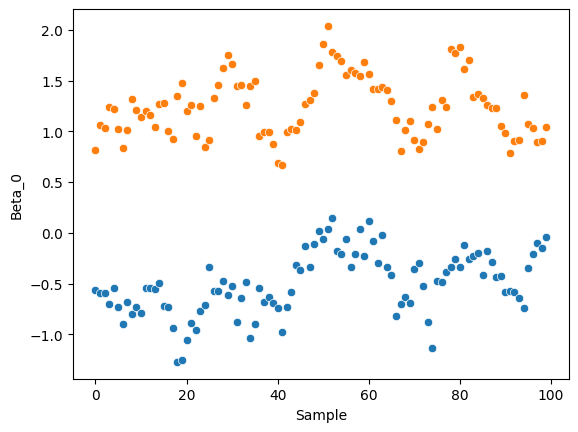

In [9]:
b_df_mcmc = pd.DataFrame(np.concatenate((np.expand_dims(np.arange(bcf_model.num_samples - bcf_model.num_gfr),axis=1), np.expand_dims(bcf_model.b0_samples[bcf_model.num_gfr:],axis=1), np.expand_dims(bcf_model.b1_samples[bcf_model.num_gfr:],axis=1)), axis = 1), columns=["Sample", "Beta_0", "Beta_1"])
sns.scatterplot(data=b_df_mcmc, x="Sample", y="Beta_0")
sns.scatterplot(data=b_df_mcmc, x="Sample", y="Beta_1")
plt.show()